In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "GATA"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn000061,MGPVDGKSSFYSPKHSSDDINYLLEFSYDDYRCMDLLSIFPESETT...,270,1
1,Achn029831,MYGHTQSMNASDRFAAAEDDSSAGGDDSVGIDGVEVVPPDAVYGDG...,213,1
2,Achn041731,MAAANPRPLQARPYEDYVQLPAIQIEDDEDGEYEDGGDDDMEEADG...,309,1
3,Achn050821,METPELLAGGYFSPGSRYFEKKSTENVNNHFAIDDLLDFSKEDDVM...,314,1
4,Achn075641,MDYVEAALKPSFEPPKKAQSQPQAFSVDSPAVNGVSGDDFFVDDLL...,303,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
9260,0.011561,0.000000,0.000000,0.011561,0.00000,0.014451,0.000000,0.000000,0.002890,0.000000,...,0.005780,0.008671,0.005780,0.000000,0.002890,0.000000,0.000000,0.0,0.0,0.002890
1694,0.006024,0.002410,0.002410,0.001205,0.00000,0.006024,0.001205,0.004819,0.003614,0.007229,...,0.000000,0.002410,0.001205,0.003614,0.002410,0.000000,0.001205,0.0,0.0,0.001205
9998,0.002421,0.000000,0.002421,0.002421,0.00000,0.000000,0.000000,0.000000,0.002421,0.004843,...,0.002421,0.002421,0.002421,0.000000,0.000000,0.000000,0.002421,0.0,0.0,0.000000
783,0.018277,0.002611,0.000000,0.002611,0.00000,0.000000,0.000000,0.000000,0.005222,0.002611,...,0.000000,0.002611,0.002611,0.000000,0.002611,0.002611,0.000000,0.0,0.0,0.000000
3377,0.029520,0.003690,0.011070,0.000000,0.00738,0.003690,0.000000,0.000000,0.003690,0.003690,...,0.000000,0.000000,0.000000,0.007380,0.003690,0.000000,0.003690,0.0,0.0,0.000000


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (8511, 441)
X_test: (2128, 441)
y_train: (8511,)
y_test: (2128,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 51s 486ms/step - accuracy: 0.5000 - loss: 0.6929

 32/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5182 - loss: 0.6855   

 65/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5779 - loss: 0.6500

 97/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6374 - loss: 0.5955

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6539 - loss: 0.5767 - val_accuracy: 0.9794 - val_loss: 0.0763


Epoch 2/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0463

 30/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9707 - loss: 0.0905

 59/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9711 - loss: 0.0899

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9714 - loss: 0.0892

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9715 - loss: 0.0886 - val_accuracy: 0.9800 - val_loss: 0.0600


Epoch 3/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0813

 31/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9804 - loss: 0.0663

 61/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9809 - loss: 0.0649

 92/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.0630

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9818 - loss: 0.0615 - val_accuracy: 0.9806 - val_loss: 0.0666


Epoch 4/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0502

 31/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9843 - loss: 0.0475

 60/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9854 - loss: 0.0452

 89/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9853 - loss: 0.0453

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9850 - loss: 0.0465 - val_accuracy: 0.9695 - val_loss: 0.0898


Epoch 5/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.1494

 32/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9799 - loss: 0.0681

 62/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 0.0570

 91/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9848 - loss: 0.0520

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9848 - loss: 0.0519 - val_accuracy: 0.9753 - val_loss: 0.0796


Epoch 6/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0230

 32/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.0539

 61/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9838 - loss: 0.0475

 91/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9851 - loss: 0.0441

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.0429 - val_accuracy: 0.9841 - val_loss: 0.0573


Epoch 7/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0232

 30/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0283

 61/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0321

 91/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9894 - loss: 0.0318

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0317 - val_accuracy: 0.9794 - val_loss: 0.0635


Epoch 8/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0602

 31/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0235

 62/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0246

 92/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0244

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0243 - val_accuracy: 0.9800 - val_loss: 0.0637


Epoch 9/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0780

 31/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9890 - loss: 0.0376

 62/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9892 - loss: 0.0350

 92/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0332

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.0330 - val_accuracy: 0.9794 - val_loss: 0.0601


Epoch 10/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0480

 31/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0229

 62/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0215

 93/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0218

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0219 - val_accuracy: 0.9800 - val_loss: 0.0660


Epoch 11/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0040

 31/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0183

 61/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0194

 90/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0193

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0192 - val_accuracy: 0.9824 - val_loss: 0.0701


Epoch 12/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0090

 31/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0095

 60/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0118

 90/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0143

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0153 - val_accuracy: 0.9812 - val_loss: 0.0661


Epoch 13/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0091

 32/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0170

 62/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0216

 92/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0229

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0231 - val_accuracy: 0.9777 - val_loss: 0.0968


Epoch 14/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0064

 31/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9860 - loss: 0.0277

 61/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9883 - loss: 0.0257

 93/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0241

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9901 - loss: 0.0236 - val_accuracy: 0.9794 - val_loss: 0.0674


Epoch 15/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0055

 30/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0124

 60/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0145

 89/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0154

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0160 - val_accuracy: 0.9765 - val_loss: 0.0927


Epoch 16/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0082

 31/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0146

 62/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0150

 93/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0154

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0153 - val_accuracy: 0.9812 - val_loss: 0.0738



[Train Accuracy: 99.66% - Test Accuracy: 98.83%]


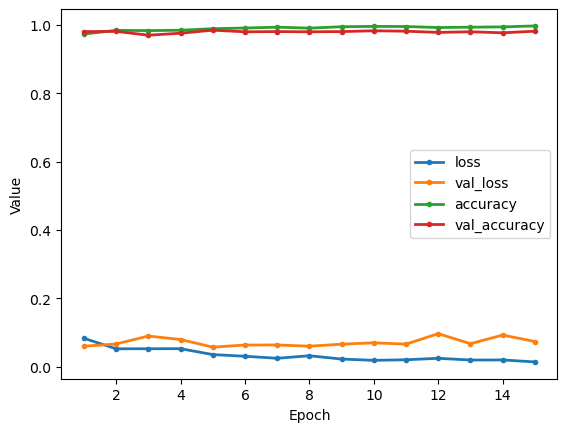

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/67 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step


 1/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
9260,0.000000,0.0,0.000000,0.002899,0.000000,0.002899,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.002899,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1694,0.001206,0.0,0.000000,0.000000,0.000000,0.001206,0.0,0.001206,0.0,0.001206,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
783,0.005236,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3377,0.011111,0.0,0.003704,0.000000,0.003704,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (8511, 8888)
X_test: (2128, 8888)
y_train: (8511,)
y_test: (2128,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,275,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,318,849 (8.85 MB)

 Trainable params: 2,318,849 (8.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 54s 516ms/step - accuracy: 0.5000 - loss: 0.6931

  9/107 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5214 - loss: 0.6929   

 18/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5507 - loss: 0.6920

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5983 - loss: 0.6898

 36/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6397 - loss: 0.6852

 45/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6737 - loss: 0.6764

 53/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6984 - loss: 0.6638

 61/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7191 - loss: 0.6473

 69/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7368 - loss: 0.6284

 78/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7538 - loss: 0.6062

 87/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7685 - loss: 0.5840

 96/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7813 - loss: 0.5628

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7924 - loss: 0.5430

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7958 - loss: 0.5367 - val_accuracy: 0.9836 - val_loss: 0.0413


Epoch 2/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9688 - loss: 0.0423

  9/107 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9850 - loss: 0.0336 

 18/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9887 - loss: 0.0298

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9896 - loss: 0.0292

 36/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9898 - loss: 0.0291

 44/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9901 - loss: 0.0287

 53/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9903 - loss: 0.0283

 62/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9905 - loss: 0.0278

 71/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9907 - loss: 0.0273

 80/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9910 - loss: 0.0268

 89/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9912 - loss: 0.0262

 98/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9915 - loss: 0.0257

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9917 - loss: 0.0252

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9917 - loss: 0.0252 - val_accuracy: 0.9906 - val_loss: 0.0274


Epoch 3/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0201

 10/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0122 

 19/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0110

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0104

 36/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0101

 45/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0098

 53/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0095

 62/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0091

 71/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0088

 79/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0085

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0083

 97/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0081

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0080

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9983 - loss: 0.0079 - val_accuracy: 0.9935 - val_loss: 0.0191


Epoch 4/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 9.6927e-04

  9/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015     

 18/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0017

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0018

 36/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0018

 45/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0017

 53/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0017

 61/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0017

 69/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0018

 78/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0019

 86/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0020

 94/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0020

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0020

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9997 - loss: 0.0020 - val_accuracy: 0.9941 - val_loss: 0.0213


Epoch 5/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 9.0057e-04

 10/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012     

 19/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0012

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0013

 37/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0014

 46/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0013

 54/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0013

 62/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0013

 71/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0013

 79/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0013

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0013

 97/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0013

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 0.0013

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9935 - val_loss: 0.0222


Epoch 6/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 8.5830e-05

 10/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4853e-04 

 19/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7909e-04

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8497e-04

 36/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8996e-04

 44/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0584e-04

 52/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3272e-04

 60/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5359e-04

 68/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6819e-04

 77/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7865e-04

 86/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8513e-04

 94/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8811e-04

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8934e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.8963e-04 - val_accuracy: 0.9941 - val_loss: 0.0230


Epoch 7/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.5600e-04

  9/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6022e-04 

 18/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6806e-04

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7336e-04

 36/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7207e-04

 45/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7564e-04

 54/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7664e-04

 62/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7630e-04

 71/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7630e-04

 79/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7609e-04

 88/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7606e-04

 97/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7656e-04

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7781e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.7825e-04 - val_accuracy: 0.9935 - val_loss: 0.0251


Epoch 8/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.0601e-04

  9/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4924e-04 

 18/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1943e-04

 26/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9623e-04

 35/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7754e-04

 43/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6646e-04

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5977e-04

 60/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5274e-04

 68/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4708e-04

 76/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4206e-04

 85/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3729e-04

 93/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3356e-04

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3118e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.2942e-04 - val_accuracy: 0.9935 - val_loss: 0.0252


Epoch 9/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 5.4571e-05

 10/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4039e-05 

 19/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5436e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4500e-05

 37/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4431e-05

 45/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3452e-05

 54/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4876e-05

 62/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.6517e-05

 71/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7717e-05

 80/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.8867e-05

 89/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9974e-05

 98/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0798e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.1641e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.1718e-05 - val_accuracy: 0.9941 - val_loss: 0.0256


Epoch 10/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 7.3312e-05

  9/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.8487e-05 

 18/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0039e-05

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3153e-05

 36/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5612e-05

 45/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.6880e-05

 53/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.1514e-05

 61/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.4420e-05

 69/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.5929e-05

 77/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6723e-05

 85/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7052e-05

 94/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6938e-05

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6592e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 8.6242e-05 - val_accuracy: 0.9941 - val_loss: 0.0270


Epoch 11/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.1424e-05

  9/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3703e-04 

 17/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0857e-04

 25/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.4009e-05

 34/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.3494e-05

 42/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.8102e-05

 51/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3062e-05

 59/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.9613e-05

 68/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.7256e-05

 77/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5738e-05

 86/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.4178e-05

 95/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2629e-05

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.1153e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.0574e-05 - val_accuracy: 0.9935 - val_loss: 0.0257


Epoch 12/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.5789e-05

 10/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0119e-05 

 19/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1734e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6879e-05

 37/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9199e-05

 46/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0269e-05

 55/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0766e-05

 64/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0943e-05

 73/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1202e-05

 82/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2122e-05

 91/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2897e-05

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.3683e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.5461e-05 - val_accuracy: 0.9935 - val_loss: 0.0290


Epoch 13/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 8.1899e-06

  9/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5956e-05 

 18/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4296e-05

 27/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0211e-05

 35/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3366e-05

 43/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5327e-05

 52/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5926e-05

 61/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5826e-05

 69/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5309e-05

 78/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.4552e-05

 87/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3909e-05

 96/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3356e-05

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2827e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.2609e-05 - val_accuracy: 0.9941 - val_loss: 0.0268


Epoch 14/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.1089e-05

  9/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6264e-05 

 17/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6832e-05

 25/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7339e-05

 33/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7671e-05

 41/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7715e-05

 50/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7675e-05

 58/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7644e-05

 67/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8159e-05

 76/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8673e-05

 85/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9680e-05

 94/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0619e-05

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1469e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.1865e-05 - val_accuracy: 0.9935 - val_loss: 0.0265



[Train Accuracy: 100.00% - Test Accuracy: 99.67%]


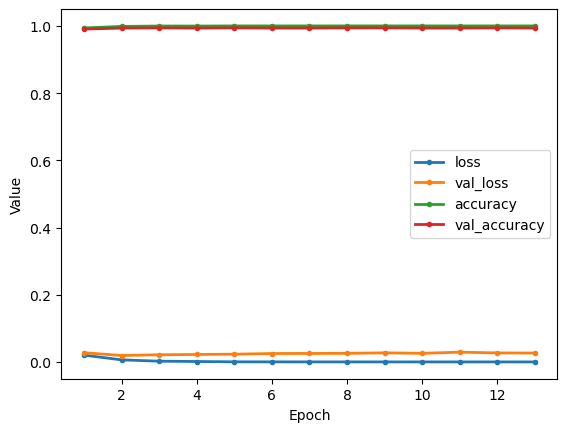

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/67 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 1/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
9260,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1694,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001208,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
783,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3377,0.007435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      39,287,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,328,257 (150.03 MB)

 Trainable params: 39,328,257 (150.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 1:13 690ms/step - accuracy: 0.5781 - loss: 0.6931

  2/107 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.5547 - loss: 0.6932 

  3/107 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.5486 - loss: 0.6932

  4/107 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.5423 - loss: 0.6932

  5/107 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.5401 - loss: 0.6931

  6/107 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.5395 - loss: 0.6931

  7/107 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.5399 - loss: 0.6930

  8/107 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.5388 - loss: 0.6929

  9/107 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.5380 - loss: 0.6928

 10/107 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.5364 - loss: 0.6928

 11/107 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.5349 - loss: 0.6927

 12/107 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.5341 - loss: 0.6927

 13/107 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.5351 - loss: 0.6926

 14/107 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.5380 - loss: 0.6925

 15/107 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.5417 - loss: 0.6924

 16/107 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.5459 - loss: 0.6923

 17/107 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.5499 - loss: 0.6922

 18/107 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.5542 - loss: 0.6921

 19/107 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.5590 - loss: 0.6920

 20/107 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.5641 - loss: 0.6918

 21/107 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.5693 - loss: 0.6916

 22/107 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.5747 - loss: 0.6914

 23/107 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.5802 - loss: 0.6912 

 24/107 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.5856 - loss: 0.6910

 25/107 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.5910 - loss: 0.6907

 26/107 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.5964 - loss: 0.6905

 27/107 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.6017 - loss: 0.6902

 28/107 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.6069 - loss: 0.6899

 29/107 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.6119 - loss: 0.6895

 30/107 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.6168 - loss: 0.6892

 31/107 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.6214 - loss: 0.6888

 32/107 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6260 - loss: 0.6884

 33/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.6305 - loss: 0.6880

 34/107 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6349 - loss: 0.6875

 35/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.6392 - loss: 0.6870

 36/107 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6434 - loss: 0.6864

 37/107 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.6474 - loss: 0.6859

 38/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.6513 - loss: 0.6853

 39/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.6551 - loss: 0.6846

 40/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.6588 - loss: 0.6839

 41/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.6624 - loss: 0.6832

 42/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.6660 - loss: 0.6824

 43/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.6694 - loss: 0.6815

 44/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.6728 - loss: 0.6806

 45/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6761 - loss: 0.6797

 46/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6794 - loss: 0.6787

 47/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6825 - loss: 0.6776

 48/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6856 - loss: 0.6765

 49/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6886 - loss: 0.6753

 50/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6916 - loss: 0.6741

 51/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6944 - loss: 0.6728

 52/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6972 - loss: 0.6715

 53/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6999 - loss: 0.6701

 54/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.7026 - loss: 0.6686

 55/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.7053 - loss: 0.6671

 56/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.7078 - loss: 0.6655

 57/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.7104 - loss: 0.6638

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.7128 - loss: 0.6621

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.7152 - loss: 0.6604

 60/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7176 - loss: 0.6586

 61/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7199 - loss: 0.6568

 62/107 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.7222 - loss: 0.6549

 63/107 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.7244 - loss: 0.6530

 64/107 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.7266 - loss: 0.6510

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.7288 - loss: 0.6490

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.7309 - loss: 0.6470

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.7330 - loss: 0.6449

 68/107 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.7350 - loss: 0.6429

 69/107 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.7370 - loss: 0.6407

 70/107 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.7390 - loss: 0.6386

 71/107 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.7409 - loss: 0.6364

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.7428 - loss: 0.6343

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.7447 - loss: 0.6321

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.7466 - loss: 0.6298

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.7484 - loss: 0.6276

 76/107 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7501 - loss: 0.6254

 77/107 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7519 - loss: 0.6232

 78/107 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7536 - loss: 0.6209

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7552 - loss: 0.6187

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7569 - loss: 0.6164

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7585 - loss: 0.6142

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7601 - loss: 0.6119

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7617 - loss: 0.6097

 84/107 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7632 - loss: 0.6074

 85/107 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7648 - loss: 0.6052

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7663 - loss: 0.6030

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7678 - loss: 0.6007

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7692 - loss: 0.5985

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7706 - loss: 0.5963

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7721 - loss: 0.5941

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7734 - loss: 0.5918

 92/107 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7748 - loss: 0.5896

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7762 - loss: 0.5874

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7775 - loss: 0.5853

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7788 - loss: 0.5831

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7801 - loss: 0.5809

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7814 - loss: 0.5787

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7827 - loss: 0.5766

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7839 - loss: 0.5745

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7851 - loss: 0.5723

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7864 - loss: 0.5702

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7875 - loss: 0.5681

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7887 - loss: 0.5660

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7899 - loss: 0.5639

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7910 - loss: 0.5618

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7922 - loss: 0.5597

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7933 - loss: 0.5577

107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.7944 - loss: 0.5557 - val_accuracy: 0.9918 - val_loss: 0.0242


Epoch 2/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 26s 248ms/step - accuracy: 0.9844 - loss: 0.0220

  2/107 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9844 - loss: 0.0250

  3/107 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9861 - loss: 0.0235

  4/107 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9876 - loss: 0.0217

  5/107 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9889 - loss: 0.0206

  6/107 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9898 - loss: 0.0196

  7/107 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9907 - loss: 0.0188

  8/107 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.9913 - loss: 0.0180

  9/107 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9917 - loss: 0.0175

 10/107 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9921 - loss: 0.0170

 11/107 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9924 - loss: 0.0166

 12/107 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9927 - loss: 0.0161

 13/107 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9930 - loss: 0.0158

 14/107 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9932 - loss: 0.0155

 15/107 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9934 - loss: 0.0153

 16/107 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9935 - loss: 0.0150

 17/107 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9937 - loss: 0.0148

 18/107 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9939 - loss: 0.0146

 19/107 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9940 - loss: 0.0144

 20/107 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9940 - loss: 0.0144

 21/107 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9941 - loss: 0.0143

 22/107 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9942 - loss: 0.0143

 23/107 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9942 - loss: 0.0142

 24/107 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9943 - loss: 0.0141

 25/107 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9944 - loss: 0.0141

 26/107 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9945 - loss: 0.0140

 27/107 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9946 - loss: 0.0139

 28/107 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9946 - loss: 0.0138

 29/107 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9947 - loss: 0.0138

 30/107 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9948 - loss: 0.0137

 31/107 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9948 - loss: 0.0136

 32/107 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9949 - loss: 0.0135 

 33/107 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9950 - loss: 0.0134

 34/107 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9951 - loss: 0.0133

 35/107 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9951 - loss: 0.0133

 36/107 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9952 - loss: 0.0132

 37/107 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9952 - loss: 0.0131

 38/107 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9953 - loss: 0.0130

 39/107 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9954 - loss: 0.0129

 40/107 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9954 - loss: 0.0128

 41/107 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9955 - loss: 0.0128

 42/107 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9955 - loss: 0.0127

 43/107 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9956 - loss: 0.0126

 44/107 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9956 - loss: 0.0125

 45/107 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9957 - loss: 0.0124

 46/107 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9957 - loss: 0.0124

 47/107 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9958 - loss: 0.0123

 48/107 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9958 - loss: 0.0122

 49/107 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9959 - loss: 0.0121

 50/107 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9959 - loss: 0.0121

 51/107 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9960 - loss: 0.0120

 52/107 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9960 - loss: 0.0119

 53/107 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9960 - loss: 0.0119

 54/107 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9961 - loss: 0.0118

 55/107 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9961 - loss: 0.0118

 56/107 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9961 - loss: 0.0117

 57/107 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9962 - loss: 0.0117

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9962 - loss: 0.0116

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9962 - loss: 0.0116

 60/107 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9963 - loss: 0.0115

 61/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9963 - loss: 0.0115

 62/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9963 - loss: 0.0115

 63/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9964 - loss: 0.0114

 64/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9964 - loss: 0.0114

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9964 - loss: 0.0113

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9964 - loss: 0.0113

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9965 - loss: 0.0112

 68/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9965 - loss: 0.0112

 69/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9965 - loss: 0.0112

 70/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9965 - loss: 0.0111

 71/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9966 - loss: 0.0111

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9966 - loss: 0.0110

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9966 - loss: 0.0110

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9966 - loss: 0.0110

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9966 - loss: 0.0109

 76/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9967 - loss: 0.0109

 77/107 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9967 - loss: 0.0109

 78/107 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9967 - loss: 0.0108

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9967 - loss: 0.0108

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9967 - loss: 0.0108

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9967 - loss: 0.0107

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9967 - loss: 0.0107

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9968 - loss: 0.0107

 84/107 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9968 - loss: 0.0106

 85/107 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9968 - loss: 0.0106

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9968 - loss: 0.0106

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9968 - loss: 0.0106

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9968 - loss: 0.0106

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9968 - loss: 0.0105

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9968 - loss: 0.0105

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9968 - loss: 0.0105

 92/107 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9969 - loss: 0.0105

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9969 - loss: 0.0105

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9969 - loss: 0.0104

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9969 - loss: 0.0104

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9969 - loss: 0.0104

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9969 - loss: 0.0104

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9969 - loss: 0.0104

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9969 - loss: 0.0104

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9969 - loss: 0.0103

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9969 - loss: 0.0103

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9969 - loss: 0.0103

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9969 - loss: 0.0103

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9969 - loss: 0.0103

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9970 - loss: 0.0103

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9970 - loss: 0.0103

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9970 - loss: 0.0103

107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.9970 - loss: 0.0102 - val_accuracy: 0.9953 - val_loss: 0.0254


Epoch 3/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 33s 316ms/step - accuracy: 1.0000 - loss: 0.0039

  2/107 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 1.0000 - loss: 0.0053

  3/107 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 1.0000 - loss: 0.0061

  4/107 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 0.0065

  5/107 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 1.0000 - loss: 0.0066

  6/107 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 0.0066

  7/107 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 0.0067

  8/107 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 0.0067

  9/107 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 1.0000 - loss: 0.0066

 10/107 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 1.0000 - loss: 0.0065

 11/107 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 1.0000 - loss: 0.0064

 12/107 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 0.0063

 13/107 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 0.0061

 14/107 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 0.0060

 15/107 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 0.0059

 16/107 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 0.0058

 17/107 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 0.0056

 18/107 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 0.0055

 19/107 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 0.0054

 20/107 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 0.0053

 21/107 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 0.0052

 22/107 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 0.0051

 23/107 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 0.0050

 24/107 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 0.0049

 25/107 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 0.0048

 26/107 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 0.0048

 27/107 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 0.0047 

 28/107 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 0.0046

 29/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 0.0046

 30/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 0.0045

 31/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 0.0044

 32/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 0.0044

 33/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 0.0043

 34/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 0.0043

 35/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 0.0042

 36/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 0.0042

 37/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 0.0041

 38/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 0.0041

 39/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 0.0040

 40/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 0.0040

 41/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 0.0039

 42/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 0.0039

 43/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 0.0039

 44/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 0.0038

 45/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 0.0038

 46/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 0.0038

 47/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 0.0037

 48/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 0.0037

 49/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 0.0036

 50/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 0.0036

 51/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0036

 52/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0035

 53/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0035

 54/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0035

 55/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0035

 56/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0034

 57/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0034

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0034

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0034

 60/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0033

 61/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0033

 62/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0033

 63/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0033

 64/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0032

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0032

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0032

 67/107 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0032

 68/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0031

 69/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0031

 70/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0031

 71/107 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0031

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0031

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0030

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0030

 75/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0030

 76/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0030

 77/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0030

 78/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0029

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0029

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0029

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0029

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0029

 83/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0029

 84/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0028

 85/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0028

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0028

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0028

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0028

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0028

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 0.0027

 91/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 0.0027

 92/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 0.0027

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 0.0027

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 0.0027

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 0.0027

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 0.0027

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 0.0027

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 0.0026

 99/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.0026

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0026

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0026

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0026

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0026

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0026

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0026

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0025

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0025

107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9935 - val_loss: 0.0148


Epoch 4/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 1.0000 - loss: 2.6653e-04

  2/107 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 3.2886e-04

  3/107 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 3.6009e-04

  4/107 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 3.7015e-04

  5/107 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 3.6645e-04

  6/107 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 3.6197e-04

  7/107 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 1.0000 - loss: 3.5738e-04

  8/107 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 1.0000 - loss: 3.6506e-04

  9/107 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 1.0000 - loss: 3.7156e-04

 10/107 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 1.0000 - loss: 3.7739e-04

 11/107 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 1.0000 - loss: 3.8090e-04

 12/107 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 1.0000 - loss: 3.8332e-04

 13/107 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 1.0000 - loss: 3.8503e-04

 14/107 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 3.8715e-04

 15/107 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 3.8861e-04

 16/107 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 3.8936e-04

 17/107 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 3.8958e-04

 18/107 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 3.8998e-04

 19/107 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 3.9054e-04

 20/107 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 3.9175e-04

 21/107 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 3.9252e-04

 22/107 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 3.9302e-04

 23/107 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.9315e-04

 24/107 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.9297e-04

 25/107 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.9275e-04

 26/107 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.9242e-04

 27/107 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.9271e-04

 28/107 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.9276e-04

 29/107 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 3.9266e-04

 30/107 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 3.9277e-04 

 31/107 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 3.9277e-04

 32/107 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 3.9287e-04

 33/107 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 3.9286e-04

 34/107 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 3.9286e-04

 35/107 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 3.9273e-04

 36/107 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 3.9248e-04

 37/107 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 3.9215e-04

 38/107 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 3.9177e-04

 39/107 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 3.9131e-04

 40/107 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 3.9090e-04

 41/107 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 3.9050e-04

 42/107 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 3.9004e-04

 43/107 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 3.9016e-04

 44/107 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 3.9020e-04

 45/107 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 3.9020e-04

 46/107 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 3.9016e-04

 47/107 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 3.9005e-04

 48/107 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 3.8988e-04

 49/107 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 3.8964e-04

 50/107 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 3.8940e-04

 51/107 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 3.8913e-04

 52/107 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 3.8887e-04

 53/107 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.8857e-04

 54/107 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.8819e-04

 55/107 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.8786e-04

 56/107 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.8767e-04

 57/107 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.8746e-04

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.8725e-04

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.8697e-04

 60/107 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.8667e-04

 61/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.8642e-04

 62/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.8620e-04

 63/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.8606e-04

 64/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.8587e-04

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.8564e-04

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.8538e-04

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.8510e-04

 68/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.8480e-04

 69/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.8448e-04

 70/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.8414e-04

 71/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.8383e-04

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.8349e-04

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.8317e-04

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.8288e-04

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.8257e-04

 76/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.8223e-04

 77/107 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.8189e-04

 78/107 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.8155e-04

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.8120e-04

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.8083e-04

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.8054e-04

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.8024e-04

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.7992e-04

 84/107 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.7963e-04

 85/107 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.7933e-04

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.7905e-04

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.7876e-04

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.7856e-04

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.7834e-04

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.7809e-04

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.7811e-04

 92/107 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.7811e-04

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.7809e-04

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.7805e-04

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.7799e-04

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.7791e-04

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.7784e-04

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.7777e-04

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.7767e-04

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 3.7755e-04

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 3.7742e-04

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 3.7728e-04

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 3.7713e-04

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 3.7700e-04

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 3.7686e-04

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 3.7670e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 3.7655e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 1.0000 - loss: 3.7640e-04 - val_accuracy: 0.9941 - val_loss: 0.0142


Epoch 5/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - accuracy: 1.0000 - loss: 2.9290e-04

  2/107 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 1.0000 - loss: 2.8447e-04

  3/107 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.9269e-04

  4/107 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.8735e-04

  5/107 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.7892e-04

  6/107 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.7149e-04

  7/107 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 2.6975e-04

  8/107 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 1.0000 - loss: 2.7020e-04

  9/107 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.7042e-04

 10/107 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.6926e-04

 11/107 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 2.6710e-04

 12/107 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 2.6519e-04

 13/107 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 2.6346e-04

 14/107 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 2.6687e-04

 15/107 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.6891e-04

 16/107 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.7003e-04

 17/107 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.7080e-04

 18/107 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 2.7099e-04

 19/107 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 2.7093e-04

 20/107 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 2.7081e-04

 21/107 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.7059e-04

 22/107 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.7008e-04

 23/107 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.6995e-04

 24/107 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 2.7016e-04

 25/107 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 2.7037e-04

 26/107 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 2.7035e-04

 27/107 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 2.7019e-04

 28/107 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 2.6999e-04

 29/107 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 2.6974e-04

 30/107 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 2.6946e-04

 31/107 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 2.6904e-04

 32/107 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 2.6868e-04 

 33/107 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 2.6833e-04

 34/107 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.6793e-04

 35/107 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.6745e-04

 36/107 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.6694e-04

 37/107 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.6635e-04

 38/107 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.6567e-04

 39/107 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 2.6576e-04

 40/107 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 2.6578e-04

 41/107 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 2.6578e-04

 42/107 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 2.6581e-04

 43/107 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 2.6575e-04

 44/107 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 2.6566e-04

 45/107 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 1.0000 - loss: 2.6550e-04

 46/107 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 1.0000 - loss: 2.6533e-04

 47/107 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 2.6511e-04

 48/107 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 2.6487e-04

 49/107 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 2.6458e-04

 50/107 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 2.6424e-04

 51/107 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 2.6388e-04

 52/107 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 2.6356e-04

 53/107 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 2.6325e-04

 54/107 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 2.6294e-04

 55/107 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.6263e-04

 56/107 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.6228e-04

 57/107 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.6211e-04

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.6190e-04

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.6166e-04

 60/107 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.6140e-04

 61/107 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.6112e-04

 62/107 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 2.6081e-04

 63/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.6048e-04

 64/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.6013e-04

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.5979e-04

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.5942e-04

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.5905e-04

 68/107 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.5871e-04

 69/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.5837e-04

 70/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.5802e-04

 71/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.5767e-04

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.5731e-04

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.5694e-04

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.5655e-04

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.5616e-04

 76/107 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.5579e-04

 77/107 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.5543e-04

 78/107 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.5505e-04

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.5468e-04

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5432e-04

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5395e-04

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5357e-04

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.5321e-04

 84/107 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5284e-04

 85/107 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5251e-04

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5219e-04

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5188e-04

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5156e-04

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5127e-04

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5098e-04

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.5069e-04

 92/107 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5039e-04

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.5008e-04

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.4978e-04

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.4949e-04

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.4919e-04

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.4889e-04

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.4858e-04

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.4827e-04

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.4796e-04

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.4765e-04

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.4733e-04

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.4701e-04

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.4667e-04

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.4634e-04

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.4600e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.4566e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 1.0000 - loss: 2.4533e-04 - val_accuracy: 0.9935 - val_loss: 0.0202


Epoch 6/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 37s 352ms/step - accuracy: 1.0000 - loss: 2.3116e-04

  2/107 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 2.5652e-04

  3/107 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 1.0000 - loss: 2.4795e-04

  4/107 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 2.3913e-04

  5/107 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.2819e-04

  6/107 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 2.2082e-04

  7/107 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.1321e-04

  8/107 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.0772e-04

  9/107 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.0239e-04

 10/107 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 1.9722e-04

 11/107 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 1.9312e-04

 12/107 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 1.8917e-04

 13/107 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 1.8574e-04

 14/107 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.8253e-04

 15/107 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.8103e-04

 16/107 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.7947e-04

 17/107 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.7800e-04

 18/107 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.7668e-04

 19/107 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.7544e-04

 20/107 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.7413e-04

 21/107 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.7301e-04

 22/107 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.7193e-04

 23/107 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.7087e-04

 24/107 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.6983e-04

 25/107 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.6889e-04

 26/107 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.6801e-04

 27/107 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.6731e-04

 28/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.6657e-04 

 29/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.6578e-04

 30/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.6509e-04

 31/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.6439e-04

 32/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.6374e-04

 33/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.6308e-04

 34/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 1.6243e-04

 35/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 1.6185e-04

 36/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.6127e-04

 37/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.6072e-04

 38/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.6019e-04

 39/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.5966e-04

 40/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 1.5913e-04

 41/107 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.5857e-04

 42/107 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.5802e-04

 43/107 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 1.5752e-04

 44/107 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.5701e-04

 45/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 1.5652e-04

 46/107 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.5604e-04

 47/107 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.5554e-04

 48/107 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.5504e-04

 49/107 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.5454e-04

 50/107 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.5404e-04

 51/107 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 1.5354e-04

 52/107 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.5305e-04

 53/107 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.5258e-04

 54/107 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.5217e-04

 55/107 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.5187e-04

 56/107 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.5156e-04

 57/107 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.5125e-04

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.5096e-04

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 1.5069e-04

 60/107 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.5041e-04

 61/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.5014e-04

 62/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.4988e-04

 63/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.4962e-04

 64/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.4938e-04

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.4914e-04

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.4891e-04

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.4872e-04

 68/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.4852e-04

 69/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.4832e-04

 70/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.4819e-04

 71/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.4807e-04

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.4792e-04

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.4778e-04

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.4764e-04

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.4749e-04

 76/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4734e-04

 77/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4720e-04

 78/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4705e-04

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4691e-04

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4676e-04

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4661e-04

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4646e-04

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.4631e-04

 84/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4616e-04

 85/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4600e-04

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4584e-04

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4568e-04

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4551e-04

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4535e-04

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4519e-04

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.4503e-04

 92/107 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4487e-04

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4473e-04

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4462e-04

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4450e-04

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4438e-04

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4426e-04

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.4414e-04

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.4402e-04

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.4391e-04

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.4380e-04

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.4370e-04

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.4358e-04

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.4349e-04

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.4340e-04

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.4334e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 1.4329e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 1.0000 - loss: 1.4323e-04 - val_accuracy: 0.9935 - val_loss: 0.0213


Epoch 7/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 24s 229ms/step - accuracy: 1.0000 - loss: 4.7571e-05

  2/107 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 1.0000 - loss: 1.4517e-04

  3/107 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 1.0000 - loss: 1.5947e-04

  4/107 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 1.0000 - loss: 1.6279e-04

  5/107 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.6074e-04

  6/107 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 1.6100e-04

  7/107 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 1.6112e-04

  8/107 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.5936e-04

  9/107 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.5704e-04

 10/107 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.5714e-04

 11/107 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 1.5646e-04

 12/107 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 1.5555e-04

 13/107 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.5427e-04

 14/107 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 1.5278e-04

 15/107 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.5124e-04

 16/107 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 1.4986e-04

 17/107 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 1.4864e-04

 18/107 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 1.4729e-04

 19/107 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.4587e-04

 20/107 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.4453e-04

 21/107 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.4323e-04

 22/107 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.4206e-04

 23/107 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.4088e-04

 24/107 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.3973e-04

 25/107 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.3871e-04

 26/107 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.3833e-04

 27/107 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.3790e-04

 28/107 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.3744e-04

 29/107 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.3692e-04 

 30/107 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.3637e-04

 31/107 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.3586e-04

 32/107 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.3580e-04

 33/107 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.3570e-04

 34/107 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.3553e-04

 35/107 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.3531e-04

 36/107 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.3506e-04

 37/107 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 1.3477e-04

 38/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3450e-04

 39/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3423e-04

 40/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3392e-04

 41/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3359e-04

 42/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3322e-04

 43/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3287e-04

 44/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.3252e-04

 45/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3218e-04

 46/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3182e-04

 47/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3144e-04

 48/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3111e-04

 49/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3075e-04

 50/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3040e-04

 51/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 1.3004e-04

 52/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.2973e-04

 53/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.2941e-04

 54/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.2908e-04

 55/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.2875e-04

 56/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.2842e-04

 57/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.2810e-04

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.2778e-04

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.2746e-04

 60/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.2716e-04

 61/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.2686e-04

 62/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.2656e-04

 63/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.2627e-04

 64/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.2597e-04

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.2566e-04

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.2536e-04

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.2506e-04

 68/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.2476e-04

 69/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.2446e-04

 70/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.2419e-04

 71/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.2393e-04

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.2369e-04

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.2344e-04

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.2320e-04

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 1.2295e-04

 76/107 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.2270e-04

 77/107 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.2247e-04

 78/107 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.2223e-04

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.2199e-04

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.2175e-04

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.2166e-04

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.2157e-04

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.2159e-04

 84/107 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.2160e-04

 85/107 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.2160e-04

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.2160e-04

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.2159e-04

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.2157e-04

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.2156e-04

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.2155e-04

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.2152e-04

 92/107 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.2149e-04

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.2145e-04

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.2142e-04

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.2138e-04

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.2135e-04

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.2132e-04

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.2129e-04

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.2127e-04

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.2124e-04

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.2121e-04

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.2121e-04

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.2120e-04

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.2119e-04

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.2117e-04

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.2115e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.2113e-04

107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 1.0000 - loss: 1.2111e-04 - val_accuracy: 0.9935 - val_loss: 0.0146


Epoch 8/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - accuracy: 1.0000 - loss: 5.7777e-05

  2/107 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 6.1208e-05

  3/107 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 6.3416e-05

  4/107 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 1.0000 - loss: 6.4799e-05

  5/107 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 6.7092e-05

  6/107 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 6.9102e-05

  7/107 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 7.0098e-05

  8/107 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 7.0532e-05

  9/107 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 7.0453e-05

 10/107 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 7.0722e-05

 11/107 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 7.0833e-05

 12/107 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 7.0779e-05

 13/107 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 7.0587e-05

 14/107 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 7.0400e-05

 15/107 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 7.0069e-05

 16/107 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 6.9687e-05

 17/107 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 6.9402e-05

 18/107 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 6.9007e-05

 19/107 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 6.8851e-05

 20/107 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 6.8806e-05

 21/107 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 6.9058e-05

 22/107 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 6.9345e-05

 23/107 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 6.9691e-05

 24/107 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 6.9968e-05

 25/107 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 7.0199e-05

 26/107 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 7.0403e-05

 27/107 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 7.0588e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 7.0724e-05 

 29/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 7.0913e-05

 30/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 7.1053e-05

 31/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 7.1204e-05

 32/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 7.1333e-05

 33/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 7.1426e-05

 34/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 7.1514e-05

 35/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 7.1610e-05

 36/107 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 7.1687e-05

 37/107 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 7.1743e-05

 38/107 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 7.1821e-05

 39/107 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 7.1871e-05

 40/107 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 7.1941e-05

 41/107 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 7.1992e-05

 42/107 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 7.2025e-05

 43/107 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 7.2089e-05

 44/107 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 7.2128e-05

 45/107 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 7.2151e-05

 46/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 7.2182e-05

 47/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 7.2192e-05

 48/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 7.2216e-05

 49/107 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 7.2218e-05

 50/107 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 7.2210e-05

 51/107 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 7.2199e-05

 52/107 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 7.2178e-05

 53/107 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 7.2159e-05

 54/107 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 7.2136e-05

 55/107 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 7.2108e-05

 56/107 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 7.2079e-05

 57/107 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 7.2057e-05

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 7.2042e-05

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 7.2022e-05

 60/107 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.2016e-05

 61/107 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.2016e-05

 62/107 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.2007e-05

 63/107 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.1988e-05

 64/107 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.1966e-05

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.1958e-05

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.1941e-05

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.1917e-05

 68/107 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 7.1884e-05

 69/107 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 7.1848e-05

 70/107 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 7.1806e-05

 71/107 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 7.1756e-05

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 7.1703e-05

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 7.1646e-05

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 7.1586e-05

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 7.1529e-05

 76/107 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 7.1483e-05

 77/107 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 7.1432e-05

 78/107 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 7.1386e-05

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 7.1346e-05

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 7.1311e-05

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 7.1296e-05

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 7.1276e-05

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 7.1255e-05

 84/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.1230e-05

 85/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.1202e-05

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.1176e-05

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.1162e-05

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.1148e-05

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.1131e-05

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.1109e-05

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.1084e-05

 92/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.1055e-05

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.1029e-05

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.1001e-05

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.0970e-05

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.0958e-05

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.0942e-05

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.0926e-05

 99/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.0907e-05

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.0885e-05

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.0871e-05

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.0854e-05

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.0838e-05

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.0825e-05

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.0811e-05

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.0794e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.0780e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 1.0000 - loss: 7.0766e-05 - val_accuracy: 0.9930 - val_loss: 0.0228


Epoch 9/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 23s 222ms/step - accuracy: 1.0000 - loss: 8.2695e-05

  2/107 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 1.0000 - loss: 7.2107e-05

  3/107 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 1.0000 - loss: 1.0214e-04

  4/107 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 1.0000 - loss: 1.0857e-04

  5/107 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 1.0000 - loss: 1.1042e-04

  6/107 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 1.0977e-04

  7/107 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 1.0000 - loss: 1.0856e-04

  8/107 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 1.0673e-04

  9/107 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.0453e-04

 10/107 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 1.0215e-04

 11/107 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 9.9899e-05

 12/107 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 9.8309e-05

 13/107 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 9.6804e-05

 14/107 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 9.5991e-05

 15/107 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 9.5061e-05

 16/107 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.4754e-05

 17/107 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 9.4292e-05

 18/107 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 9.3909e-05

 19/107 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 9.3459e-05

 20/107 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 9.2941e-05

 21/107 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 9.2370e-05

 22/107 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 9.2013e-05

 23/107 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 9.1579e-05

 24/107 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 9.1079e-05

 25/107 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 9.0895e-05

 26/107 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 9.0668e-05

 27/107 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 9.0416e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 9.0122e-05 

 29/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 8.9778e-05

 30/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 8.9432e-05

 31/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 8.9122e-05

 32/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 8.8770e-05

 33/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 8.8413e-05

 34/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 8.8028e-05

 35/107 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 8.7641e-05

 36/107 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 8.7252e-05

 37/107 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 8.6881e-05

 38/107 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 8.6503e-05

 39/107 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 8.6128e-05

 40/107 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 8.5760e-05

 41/107 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 8.5380e-05

 42/107 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 8.5473e-05

 43/107 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 8.5537e-05

 44/107 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 8.5571e-05

 45/107 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 8.5584e-05

 46/107 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 8.5590e-05

 47/107 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 8.5577e-05

 48/107 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 8.5532e-05

 49/107 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 8.5462e-05

 50/107 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 8.5454e-05

 51/107 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 8.5443e-05

 52/107 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 8.5414e-05

 53/107 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 8.5387e-05

 54/107 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 8.5350e-05

 55/107 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 8.5304e-05

 56/107 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 8.5239e-05

 57/107 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 8.5189e-05

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 8.5128e-05

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 8.5057e-05

 60/107 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 8.4979e-05

 61/107 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 8.4895e-05

 62/107 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 8.4804e-05

 63/107 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 8.4701e-05

 64/107 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 8.4594e-05

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 8.4480e-05

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 8.4366e-05

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 8.4253e-05

 68/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.4134e-05

 69/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.4015e-05

 70/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.3888e-05

 71/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.3757e-05

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.3621e-05

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.3500e-05

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.3378e-05

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.3258e-05

 76/107 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.3138e-05

 77/107 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.3029e-05

 78/107 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.2916e-05

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.2798e-05

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.2675e-05

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.2549e-05

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.2419e-05

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.2290e-05

 84/107 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.2162e-05

 85/107 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.2031e-05

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.1900e-05

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.1766e-05

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.1632e-05

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.1500e-05

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.1364e-05

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.1232e-05

 92/107 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.1098e-05

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.0963e-05

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.0826e-05

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.0691e-05

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.0554e-05

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.0416e-05

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.0276e-05

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.0134e-05

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.9993e-05

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.9854e-05

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.9714e-05

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.9576e-05

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.9449e-05

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.9320e-05

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.9193e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.9067e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 1.0000 - loss: 7.8943e-05 - val_accuracy: 0.9935 - val_loss: 0.0215


Epoch 10/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 29s 278ms/step - accuracy: 1.0000 - loss: 1.2653e-04

  2/107 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 9.9853e-05

  3/107 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 1.0000 - loss: 8.4921e-05

  4/107 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 1.0000 - loss: 7.5498e-05

  5/107 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 1.0000 - loss: 6.9204e-05

  6/107 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 1.0000 - loss: 6.4851e-05

  7/107 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 1.0000 - loss: 6.2047e-05

  8/107 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 1.0000 - loss: 5.9878e-05

  9/107 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 1.0000 - loss: 5.8403e-05

 10/107 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 1.0000 - loss: 5.7122e-05

 11/107 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 1.0000 - loss: 5.5899e-05

 12/107 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 1.0000 - loss: 5.4717e-05

 13/107 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 5.3692e-05

 14/107 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 5.2840e-05

 15/107 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 5.2092e-05

 16/107 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 5.1550e-05

 17/107 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 5.0989e-05

 18/107 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 5.0622e-05

 19/107 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 5.0400e-05

 20/107 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 5.0159e-05

 21/107 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 4.9940e-05

 22/107 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 4.9729e-05

 23/107 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 4.9478e-05

 24/107 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 4.9212e-05

 25/107 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 4.8928e-05

 26/107 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 4.8688e-05

 27/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 4.8446e-05 

 28/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 4.8245e-05

 29/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 4.8027e-05

 30/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 4.7818e-05

 31/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 4.7642e-05

 32/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 4.7458e-05

 33/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 4.7278e-05

 34/107 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 4.7098e-05

 35/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.6914e-05

 36/107 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 4.6723e-05

 37/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.6604e-05

 38/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.6484e-05

 39/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.6354e-05

 40/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.6223e-05

 41/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.6102e-05

 42/107 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.5981e-05

 43/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.5870e-05

 44/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.5748e-05

 45/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.5644e-05

 46/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.5548e-05

 47/107 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 4.5448e-05

 48/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.5341e-05

 49/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.5237e-05

 50/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.5133e-05

 51/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.5026e-05

 52/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.5086e-05

 53/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.5135e-05

 54/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.5173e-05

 55/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.5207e-05

 56/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.5250e-05

 57/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.5283e-05

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.5313e-05

 59/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.5338e-05

 60/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.5360e-05

 61/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.5391e-05

 62/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.5415e-05

 63/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.5437e-05

 64/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.5456e-05

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.5466e-05

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.5471e-05

 67/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.5472e-05

 68/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.5501e-05

 69/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.5522e-05

 70/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.5540e-05

 71/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.5553e-05

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.5561e-05

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.5563e-05

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.5565e-05

 75/107 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.5563e-05

 76/107 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.5563e-05

 77/107 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.5573e-05

 78/107 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.5607e-05

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.5645e-05

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.5680e-05

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.5709e-05

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.5738e-05

 83/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.5771e-05

 84/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.5801e-05

 85/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.5827e-05

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.5853e-05

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.5875e-05

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.5896e-05

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.5917e-05

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.5936e-05

 91/107 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.5953e-05

 92/107 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.5967e-05

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.5980e-05

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.5994e-05

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.6006e-05

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.6015e-05

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.6025e-05

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.6032e-05

 99/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.6035e-05

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.6042e-05

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.6048e-05

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.6058e-05

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.6064e-05

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.6072e-05

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.6077e-05

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.6080e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.6082e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 1.0000 - loss: 4.6084e-05 - val_accuracy: 0.9930 - val_loss: 0.0235


Epoch 11/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 24s 227ms/step - accuracy: 1.0000 - loss: 2.9609e-05

  2/107 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 1.0000 - loss: 3.3771e-05

  3/107 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 1.0000 - loss: 3.5942e-05

  4/107 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 1.0000 - loss: 3.6507e-05

  5/107 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 1.0000 - loss: 3.6489e-05

  6/107 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 1.0000 - loss: 3.6196e-05

  7/107 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 1.0000 - loss: 3.5901e-05

  8/107 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 1.0000 - loss: 3.6827e-05

  9/107 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 1.0000 - loss: 3.7369e-05

 10/107 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 1.0000 - loss: 3.7575e-05

 11/107 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 1.0000 - loss: 3.7556e-05

 12/107 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 1.0000 - loss: 3.7431e-05

 13/107 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 1.0000 - loss: 3.7192e-05

 14/107 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 1.0000 - loss: 3.6906e-05

 15/107 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 1.0000 - loss: 3.6593e-05

 16/107 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 1.0000 - loss: 3.6269e-05

 17/107 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 1.0000 - loss: 3.5938e-05

 18/107 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 3.6002e-05

 19/107 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 3.6008e-05

 20/107 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 3.6066e-05

 21/107 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 3.6090e-05

 22/107 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 3.6078e-05

 23/107 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 3.6037e-05

 24/107 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 3.5969e-05

 25/107 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 3.5877e-05

 26/107 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 3.5801e-05 

 27/107 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 3.5722e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 3.5617e-05

 29/107 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 3.5503e-05

 30/107 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 3.5372e-05

 31/107 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 3.5317e-05

 32/107 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 3.5554e-05

 33/107 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 3.5769e-05

 34/107 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 3.5981e-05

 35/107 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.6165e-05

 36/107 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.6323e-05

 37/107 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.6450e-05

 38/107 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.6563e-05

 39/107 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.6900e-05

 40/107 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.7198e-05

 41/107 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.7465e-05

 42/107 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.7712e-05

 43/107 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 3.7930e-05

 44/107 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 3.8130e-05

 45/107 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 3.8320e-05

 46/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.8585e-05

 47/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.8827e-05

 48/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.9082e-05

 49/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.9313e-05

 50/107 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.9521e-05

 51/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.9715e-05

 52/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.9889e-05

 53/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.0050e-05

 54/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.0192e-05

 55/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.0322e-05

 56/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.0438e-05

 57/107 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.0546e-05

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 4.0643e-05

 59/107 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 4.0728e-05

 60/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.0812e-05

 61/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.0888e-05

 62/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.0964e-05

 63/107 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.1030e-05

 64/107 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 4.1085e-05

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 4.1136e-05

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 4.1179e-05

 67/107 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.1241e-05

 68/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.1293e-05

 69/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.1335e-05

 70/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.1373e-05

 71/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.1405e-05

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.1447e-05

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.1482e-05

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.1523e-05

 75/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.1557e-05

 76/107 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.1586e-05

 77/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.1614e-05

 78/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.1638e-05

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.1655e-05

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.1669e-05

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.1681e-05

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.1689e-05

 83/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.1699e-05

 84/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.1710e-05

 85/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.1717e-05

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.1727e-05

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.1734e-05

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.1739e-05

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.1741e-05

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.1739e-05

 91/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.1735e-05

 92/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.1726e-05

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.1715e-05

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.1703e-05

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.1690e-05

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.1677e-05

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.1668e-05

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.1656e-05

 99/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.1668e-05

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.1677e-05

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.1686e-05

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.1695e-05

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.1700e-05

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.1702e-05

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.1708e-05

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.1712e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.1716e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 1.0000 - loss: 4.1719e-05 - val_accuracy: 0.9935 - val_loss: 0.0189


Epoch 12/100


  1/107 ━━━━━━━━━━━━━━━━━━━━ 30s 292ms/step - accuracy: 1.0000 - loss: 8.4650e-06

  2/107 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 1.0000 - loss: 1.1074e-05

  3/107 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 1.1710e-05

  4/107 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 1.3242e-05

  5/107 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 1.6184e-05

  6/107 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 1.8082e-05

  7/107 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 1.9223e-05

  8/107 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.0042e-05

  9/107 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.0647e-05

 10/107 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.1017e-05

 11/107 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 2.1236e-05

 12/107 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 2.1315e-05

 13/107 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 2.1392e-05

 14/107 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 2.1486e-05

 15/107 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 2.1496e-05

 16/107 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 2.1483e-05

 17/107 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 2.1443e-05

 18/107 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 2.1397e-05

 19/107 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 2.1417e-05

 20/107 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 2.1411e-05

 21/107 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 2.1405e-05

 22/107 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 2.1376e-05

 23/107 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 2.1337e-05

 24/107 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 2.1276e-05

 25/107 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 2.1218e-05

 26/107 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.1171e-05

 27/107 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.1109e-05

 28/107 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.1046e-05

 29/107 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.0974e-05 

 30/107 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.0898e-05

 31/107 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.0835e-05

 32/107 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.0767e-05

 33/107 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.0697e-05

 34/107 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.0625e-05

 35/107 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.0562e-05

 36/107 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.0514e-05

 37/107 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 2.0517e-05

 38/107 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 2.0587e-05

 39/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.0648e-05

 40/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.0696e-05

 41/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.0737e-05

 42/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.0778e-05

 43/107 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.0810e-05

 44/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.0838e-05

 45/107 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.0862e-05

 46/107 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.0882e-05

 47/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.0895e-05

 48/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.0903e-05

 49/107 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.0907e-05

 50/107 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.0910e-05

 51/107 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.0921e-05

 52/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.0929e-05

 53/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.0939e-05

 54/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.0945e-05

 55/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.0946e-05

 56/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.0947e-05

 57/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.0951e-05

 58/107 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.0951e-05

 59/107 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.0949e-05

 60/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.0945e-05

 61/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.0942e-05

 62/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.0937e-05

 63/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.0930e-05

 64/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.0923e-05

 65/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.0914e-05

 66/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.0903e-05

 67/107 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.0890e-05

 68/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.0878e-05

 69/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.0864e-05

 70/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.0849e-05

 71/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.0832e-05

 72/107 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.0813e-05

 73/107 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.0796e-05

 74/107 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.0783e-05

 75/107 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.0767e-05

 76/107 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.0751e-05

 77/107 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.0733e-05

 78/107 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.0715e-05

 79/107 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.0695e-05

 80/107 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.0674e-05

 81/107 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.0654e-05

 82/107 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.0632e-05

 83/107 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.0610e-05

 84/107 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.0589e-05

 85/107 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.0566e-05

 86/107 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.0544e-05

 87/107 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.0521e-05

 88/107 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 2.0508e-05

 89/107 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 2.0493e-05

 90/107 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 2.0479e-05

 91/107 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 2.0465e-05

 92/107 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 2.0451e-05

 93/107 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 2.0435e-05

 94/107 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.0419e-05

 95/107 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.0402e-05

 96/107 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.0385e-05

 97/107 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.0369e-05

 98/107 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.0353e-05

 99/107 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.0335e-05

100/107 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 2.0318e-05

101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 2.0300e-05

102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 2.0282e-05

103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.0263e-05

104/107 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.0244e-05

105/107 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.0225e-05

106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.0204e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.0183e-05

107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 1.0000 - loss: 2.0163e-05 - val_accuracy: 0.9935 - val_loss: 0.0238



[Train Accuracy: 100.00% - Test Accuracy: 99.39%]


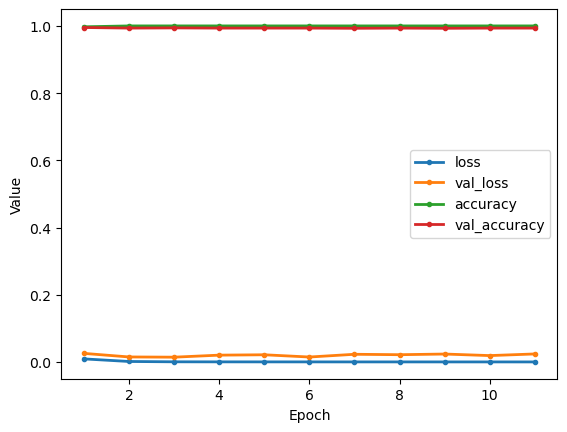

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/67 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step

 6/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

11/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

26/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

31/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

36/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

41/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

46/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

51/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

57/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

63/67 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


 1/67 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step

 6/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

11/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

26/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

31/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

36/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

41/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

46/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

51/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

56/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

62/67 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [25]:
report.save()

Report saved as Output/Reports/GATA/report_0FT6NECM.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################